In [4]:
from wrangle import *


In [5]:
programs = programs_dict()


dict_keys(['All', 'DS', 'Front_End', 'Full_Stack_PHP'])


# Questions:

1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

7. Which lessons are least accessed?


In [6]:
# Question 1
# 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
ds = programs["DS"]


In [7]:

ds_q1 = q1(ds)
ds_q1


,lesson,count
0,classification/overview,1785


In [8]:
full_stack = programs["Full_Stack_PHP"]
full_stack_q1 = q1(full_stack)
full_stack_q1


,lesson,count
0,javascript-i,18193


In [9]:
front_end = programs["Front_End"]
front_end_q1 = q1(front_end)
front_end_q1
# since front end is such a small number I will not use them going forward


,lesson,count
0,content/html-css,2


In [10]:
# Question 2
# 2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

ds_q2 = question2(ds)
ds_q2


,lesson,max_z_score,name,count
0,anomaly-detection/overview,1.767054,Darden,592
1,sql/mysql-overview,1.682628,Darden,774
2,classification/overview,1.667019,Darden,1109
3,fundamentals/intro-to-data-science,1.416839,Florence,615
4,3-sql/1-mysql-overview,1.413467,Curie,441
5,stats/compare-means,1.342333,Darden,423
6,1-fundamentals/1.1-intro-to-data-science,1.135807,Bayes,640
7,python/data-types-and-variables,1.043553,Florence,258
8,1-fundamentals/1.2-data-science-pipeline,0.969793,Darden,284
9,6-regression/1-overview,0.689207,Curie,595


In [11]:
full_stack_q2 = question2(full_stack[full_stack.name != "Staff"])
full_stack_q2


,lesson,max_z_score,name,count
0,toc,2.893278,Jupiter,1866
1,spring,1.828492,Teddy,744
2,html-css,1.797995,Jupiter,784
3,java-ii,1.669692,Voyageurs,756
4,javascript-i,1.638452,Ceres,1003
5,java-iii,1.617244,Jupiter,795
6,jquery,1.566463,Ceres,637


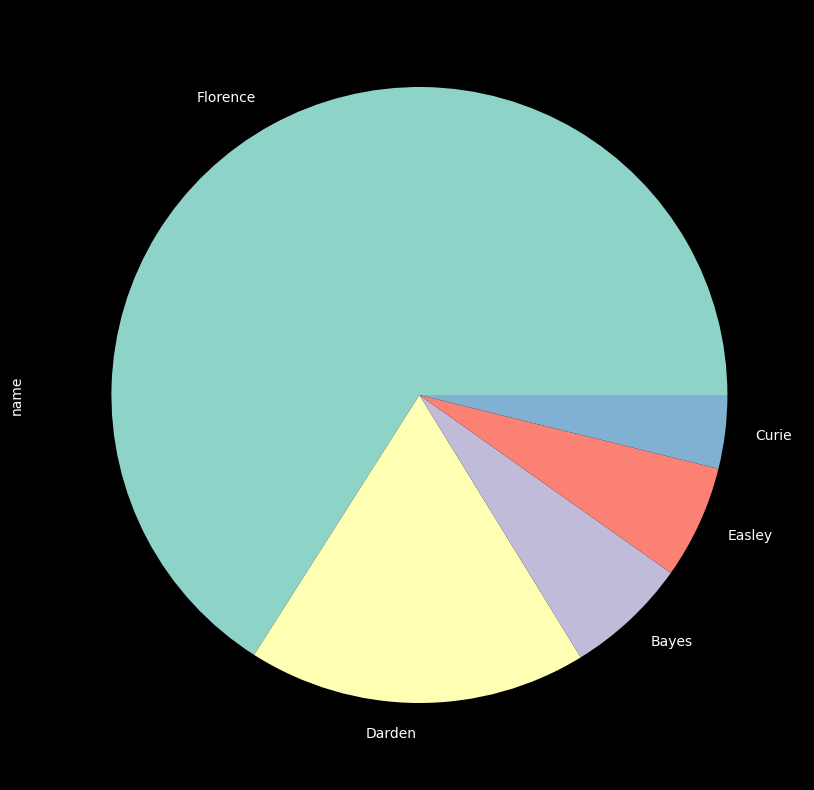

,name,id,count
0,Darden,679,4
1,Darden,697,7
2,Bayes,487,16
3,Easley,839,46
4,Florence,902,116
5,Florence,906,148
6,Darden,780,152
7,Florence,904,160
8,Florence,899,189
9,Florence,905,194


In [12]:
# Question 3
# 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
merged = programs["All"]

question3(ds)


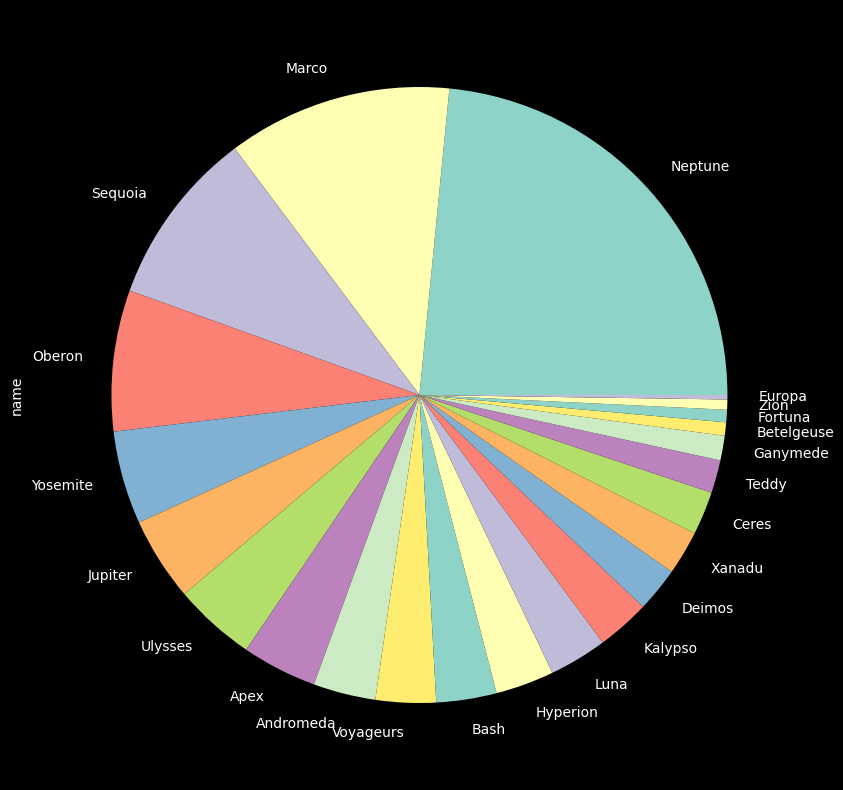

,name,id,count
0,Jupiter,832,2
1,Luna,663,2
2,Voyageurs,278,3
3,Oberon,956,4
4,Europa,539,4
...,...,...,...
152,Marco,884,306
153,Apex,594,310
154,Kalypso,797,312
155,Marco,871,319


In [13]:

question3(full_stack[full_stack.name != "Staff"])


In [14]:
# Question 4
# Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? 
# Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?
merged = programs["All"]

q4(ds)

q4(full_stack[full_stack.name != "Staff"])




,id,name,mode,nunique
0,843,Easley,172.58.99.111,122
1,690,Darden,67.11.40.170,86


,id,name,mode,nunique
0,228,Wrangell,97.105.19.58,148
1,533,Europa,205.251.148.178,91
2,530,Europa,97.105.19.58,86
3,226,Wrangell,97.105.19.58,83
4,460,Ceres,89.187.164.151,81
5,127,Ulysses,97.105.19.61,61
6,337,Zion,97.105.19.58,56
7,570,Fortuna,172.124.67.93,49


- These ids are suspicious because they have very high number of ips associated with the same id. 
- They are above the .95 quantile.


In [15]:
# 5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off.
# Do you see any evidence of that happening? Did it happen before?


In [16]:
#6. What topics are grads continuing to reference after graduation and into their jobs (for each program)

q6_ds=q6(ds)
q6_ds



,page,count
0,sql/mysql-overview,275
1,classification/overview,267
2,anomaly-detection/overview,191
3,fundamentals/intro-to-data-science,184
4,1-fundamentals/1.1-intro-to-data-science,127
5,sql/database-design,87
6,6-regression/1-overview,86
7,classification/prep,77
8,fundamentals/environment-setup,76
9,stats/compare-means,73


In [17]:

q6_full_stack=q6(full_stack[full_stack.name!='Staff'])
q6_full_stack

,page,count
0,javascript-i,3152
1,spring,2869
2,html-css,2403
3,java-i,2275
4,java-ii,2184
5,java-iii,2148
6,javascript-ii,1988
7,appendix,1798
8,mysql,1689
9,toc,1663


In [18]:
#7 Which lessons are least accessed?

q7_ds=q7(ds)
q7_ds


,page,count
0,2.1-spreadsheets-overview,1
1,3-vocabulary,1
2,4-python/pandas-lesson,1
3,4.2-compare-means,1
4,5-detecting-with-clustering,1
5,7.4.1-pandas-overview,1
6,7.4.2-series,1
7,9-timeseries/6.1-parametric-modeling,1
8,A-clustering/project,1
9,acquire-and-prep,1


In [19]:

q7_full_stack=q7(full_stack[full_stack.name!='Staff'])
q7_full_stack



,page,count
0,02_listing_files,1
1,03_file_paths,1
2,04_navigating_the_filesystem,1
3,05_creating_files_and_directories,1
4,1-fundamentals/2.4-more-excel-features,1
5,1-fundamentals/project,1
6,10.01_Acquire_WebScraping,1
7,10.02.01_ParseText,1
8,10.10_Exercises,1
9,10._NLP,1


We can see that the groups of lessons below had very low hits over all. I removed files that where likely not useful.
